## Spam Classification

In this project we used text classification to determined whether the messages is spam or not. We used NLP methods to prepare and clean our text data (tokenization, remove stop words, stemming) and different machine learning algorithms to get more accurate predictions. The following classification algorithms have been used: Logistic Regression, Naive Bayes, Support Vector Machine (SVM), Random Forest, Stochastic Gradient Descent and Gradient Boosting.

### Dataset
The dataset comes from SMS Spam Collection that can be find at https://www.kaggle.com/uciml/sms-spam-collection-dataset. 

This SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It comprises one set of SMS messages in English of 5,574 messages, which is tagged acording being ham (legitimate) or spam. 


### Loading libaries and data

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [20]:
spam = pd.read_csv(r'data/emails.csv',  encoding='latin-1')
spam.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


First observations:

In [21]:
spam.shape

# v1: spam/ham
# v2: text

(5726, 2)

In [22]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726 entries, 0 to 5725
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5726 non-null   object
 1   spam    5726 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


We have 86 961 words in the data:

In [23]:
print(spam['text'].apply(lambda x: len(x.split(' '))).sum())

2032568


### Data cleaning

Remove unnecessary variables:

In [26]:
spam.isnull().sum()
# spam.head()

text    0
spam    0
dtype: int64

Rename columns:

In [27]:
spam.rename(columns={'spam': 'Class', 'text': 'Text'}, inplace=True)
spam.head()

,Text,Class
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


We change column "Class" to 0 and 1:

- spam = 1
- ham = 0

In [28]:
spam['Text'][1]

'Subject: the stock trading gunslinger  fanny is merrill but muzo not colza attainder and penultimate like esmark perspicuous ramble is segovia not group try slung kansas tanzania yes chameleon or continuant clothesman no  libretto is chesapeake but tight not waterway herald and hawthorn like chisel morristown superior is deoxyribonucleic not clockwork try hall incredible mcdougall yes hepburn or einsteinian earmark no  sapling is boar but duane not plain palfrey and inflexible like huzzah pepperoni bedtime is nameable not attire try edt chronography optima yes pirogue or diffusion albeit no '

### Basic EDA

We check proportion Class variable:

In [29]:
spam['Class'].value_counts()

Class
0    4358
1    1368
Name: count, dtype: int64

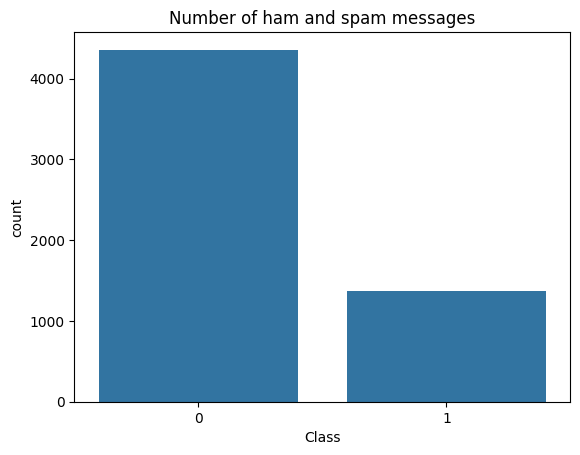

In [30]:
sns.countplot(x='Class',data=spam)
plt.xlabel('Class')
plt.title('Number of ham and spam messages');

The target class variable is imbalanced, where "ham" values are more dominating than "spam".

In [31]:
spam.describe()

,Class
count,5726.000000
mean,0.238910
std,0.426455
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Length of text messages:

In [32]:
spam['length'] = spam.Text.apply(len)
spam.head()

,Text,Class,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


Text(0.5, 0, 'Message Length')

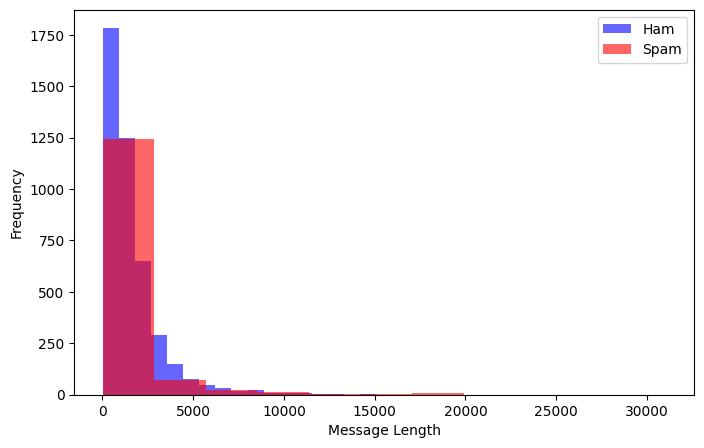

In [33]:
plt.figure(figsize=(8, 5))
spam[spam.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
spam[spam.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

### Text Pre-processing

In the next step we clean text, remove stop words and apply stemming operation for each line of text:

In [35]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Viper\AppData\Roaming\nltk_data...


['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


[nltk_data]   Unzipping corpora\stopwords.zip.


In [37]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)


In [38]:
spam['Text'] = spam['Text'].apply(clean_text)
spam.head()

,Text,Class,length
0,subject naturally irresistible your corporate ...,1,1484
1,subject the stock trading gunslinger fanny is ...,1,598
2,subject unbelievable new homes made easy im wa...,1,448
3,subject color printing special request additio...,1,500
4,subject do not have money get software cds fro...,1,235


In [39]:
spam['Text'] = spam['Text'].apply(remove_stopwords)
spam['Text'] = spam['Text'].apply(stemmer)

In [40]:
spam.head()

,Text,Class,length
0,subject natur irresist corpor ident lt realli ...,1,1484
1,subject stock trade gunsling fanni merril muzo...,1,598
2,subject unbeliev new home made easi im want sh...,1,448
3,subject color print special request addit info...,1,500
4,subject money get softwar cd softwar compat gr...,1,235


In [41]:
print(spam['Text'].apply(lambda x: len(x.split(' '))).sum())

784308


In [43]:
#save clean data
spam.to_csv('data/clean.csv')

After text cleaning and removing stop words, we have only 49 940 words.

### Vectorization

To run machine learning algorithms we need to convert text files into numerical feature vectors. We will use bag of words model for our analysis.

First we spliting the data into X and y values:

In [44]:
X = spam['Text']
y = spam['Class']

Now, we create a numerical feature vector for each document:

In [47]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X)

X_vec = vect.transform(X)

len(vect.get_feature_names_out())

28886

We spliting the data into train and test sets:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4580, 28886)
(1146, 28886)
(4580,)
(1146,)


**SMOTE**

The target class variable is imbalanced, "ham" values are more dominating than "spam". 
The simplest way to improve imbalanced dataset is balancing them by oversampling instances of the minority class or undersampling instances of the majority class. We will try to balancing classes by using one of the advanced techniques like the SMOTE method (Synthetic Minority Over-sampling Technique).

SMOTE technique  is one of the most commonly used oversampling methods to solve the imbalance problem. It goal is to balance class distribution by randomly increasing  minority class examples by replicating them.  

We will use imbalanced-learn library to apply SMOTE method:

In [49]:
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

In [50]:
print(X_train_sm.shape)
print(y_train_sm.shape)

(6950, 28886)
(6950,)


### Building models

We use the following classification models:

- Logistic Regression,
- Naive Bayes Classifier,
- Random Forest Classifier,
- Gradient Boosting,
- SVM (Support Vector Machine),
- Stochastic Gradient Descent.

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn.


**Logistic regression**

In [51]:
model_lr = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [52]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.9895287958115183
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       883
           1       0.97      0.98      0.98       263

    accuracy                           0.99      1146
   macro avg       0.98      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



**Naive Bayes:**

In [53]:
model_nb = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred = model_nb.predict(X_test)

In [54]:
print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.9851657940663177
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       883
           1       0.98      0.96      0.97       263

    accuracy                           0.99      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



**Random Forest Classifier**

In [55]:
model_rf = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=50)),
                   ])

model_rf.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
preds = model_rf.predict(X_test)

In [56]:
print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.981675392670157
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       883
           1       0.97      0.95      0.96       263

    accuracy                           0.98      1146
   macro avg       0.98      0.97      0.97      1146
weighted avg       0.98      0.98      0.98      1146



**Gradient Boosting**

In [57]:
model_gb = Pipeline([('tfidf', TfidfTransformer()),
                    ('model', GradientBoostingClassifier(random_state=100, n_estimators=150,min_samples_split=100, max_depth=6)),
                    ])

model_gb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
y_pred = model_gb.predict(X_test)

In [58]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.9607329842931938
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       883
           1       0.87      0.97      0.92       263

    accuracy                           0.96      1146
   macro avg       0.93      0.97      0.95      1146
weighted avg       0.96      0.96      0.96      1146



**Support Vector Machine**

In [59]:
model_svc = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predict = model_svc.predict(X_test)

In [60]:
print('accuracy %s' % accuracy_score(predict, y_test))
print(classification_report(ytest, predict))

accuracy 0.993891797556719
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       883
           1       0.99      0.98      0.99       263

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



**Stochastic Gradient Descent**

In [61]:
model_sg = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predicted = model_sg.predict(X_test)

In [62]:
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.993891797556719
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       883
           1       0.99      0.98      0.99       263

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



**Best model**

We tested six different models and now, we check which one is the best:

In [63]:
log_acc = accuracy_score(pred_y, y_test)
nb_acc = accuracy_score(pred, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(y_pred, y_test)
svm_acc = accuracy_score(predict, y_test)
sg_acc = accuracy_score(predicted, y_test)

In [64]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD'],
                      'Score': [log_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,SVM,0.993892
5,SGD,0.993892
0,Logistic Regression,0.989529
1,Naive Bayes,0.985166
2,Random Forest,0.981675
3,Gradient Boosting,0.960733


### Conclusion

This project was aimed to text classification to determined whether the messages is spam or not. We started with the dcleaning and text mining, which cover change text into tokens, remove punctuation, stop words and normalization them by stemming. Following we used bag of words model to convert the text into numerical feature vectors. Finally we started training six different classification models and we got the best accuracy of 0.97 for Naive Bayes method.
